# Foundations of Data Science
*Amirmahdi Soleimanifar*  
*Student ID: 98101747*

## Homework outline
This homework consists of three questions, each aimed at one skill you are supposed to learn and get comfortable with during the course.

In *Question 1*, you are supposed to perform an observational study based on *propensity score matching*, as you learned during the course.

*Question 2*, briefly introduces you to the usage of sklearn library as well as the very basics of word vectorization.

For *Question 3*, you should get familiarized with the basics of PyTorch, which is going to be of so much use during the project.

## Question 1: Propensity score matching

In this exercise, you will apply propensity score matching that was discussed the lecture ("Observational studies"), in order to draw conclusions from an observational study. [(a reference that could help if you are interested in the concept)](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), 

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](https://www.jstor.org/stable/1806062)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.



### 1-1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups using plots, such as histograms, and other statistical measures, such as mean, median, variance, and standard deviation.

To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?



In [2]:
# Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import lalonde dataset
df = pd.read_csv('lalonde.csv', index_col='id')
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Text(0.5, 1.0, 'Histogram of real earnings in 1978 for treatment and control groups')

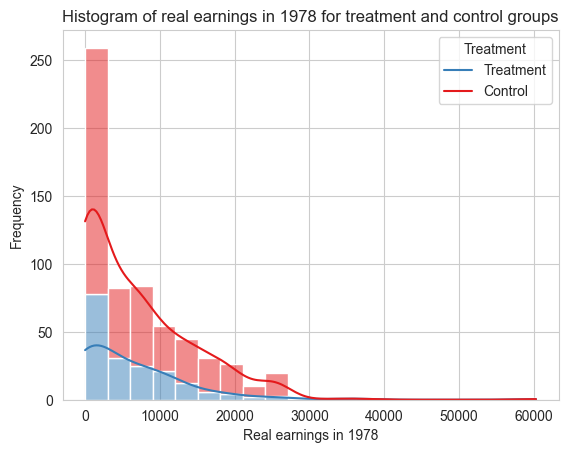

In [4]:
# Plot histogram of real earnings in 78 for treatment and control groups
sns.set_style('whitegrid')
sns.set_palette('Set1')
sns.histplot(data=df, x='re78', hue='treat', kde=True, bins=20, multiple='stack')
plt.legend(title='Treatment', loc='upper right', labels=['Treatment', 'Control'])
plt.xlabel('Real earnings in 1978')
plt.ylabel('Frequency')
plt.title('Histogram of real earnings in 1978 for treatment and control groups')

Text(0.5, 1.0, 'Histogram of real earnings for interval [0, 25000]')

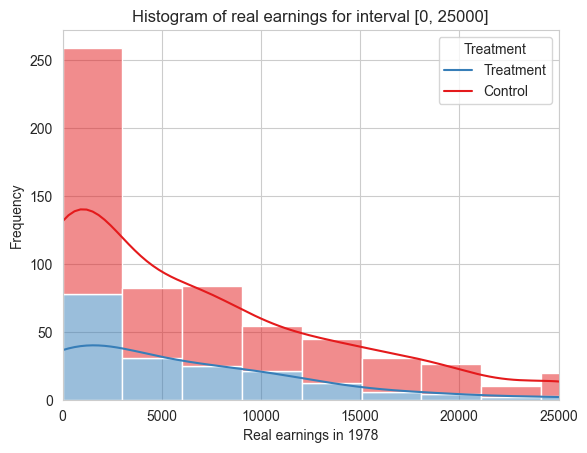

In [5]:
# Histogram for the earnings interval [0, 25000]
sns.set_style('whitegrid')
sns.set_palette('Set1')
sns.histplot(data=df, x='re78', hue='treat', kde=True, bins=20, multiple='stack')
plt.legend(title='Treatment', loc='upper right', labels=['Treatment', 'Control'])
plt.xlabel('Real earnings in 1978')
plt.xlim(0, 25000)
plt.ylabel('Frequency')
plt.title('Histogram of real earnings for interval [0, 25000]')


Text(0.5, 1.0, 'Boxplot of real earnings in 1978 for treatment and control groups')

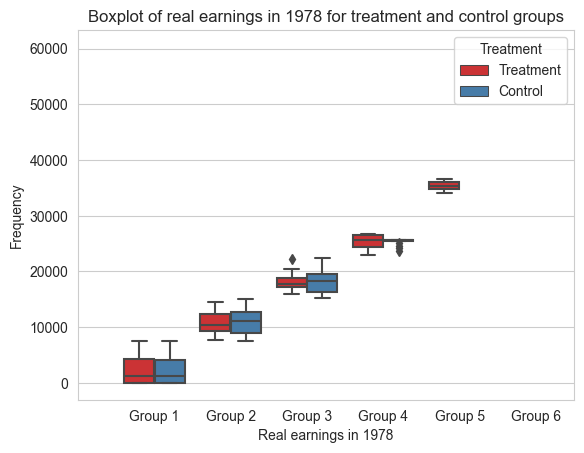

In [6]:
# Make a column and classify the real earnings in 78 into 10 categories
df_copy = df.copy()
df_copy['re78_cat'] = pd.cut(df_copy['re78'], bins=8, labels=range(1, 9))
df_copy.rename(columns={'treat': 'Treatment'}, inplace=True)
df_copy['Treatment'] = df_copy['Treatment'].replace({0: 'Control', 1: 'Treatment'})


# Plot boxplot of real earnings in 78 for treatment and control groups
sns.set_style('whitegrid')
sns.set_palette('Set1')
sns.boxplot(data=df_copy, x='re78_cat', y='re78', hue='Treatment')
plt.xlim(-1, 5.5)
plt.xticks([0, 1, 2, 3, 4, 5], ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6'])
plt.xlabel('Real earnings in 1978')
plt.ylabel('Frequency')
plt.title('Boxplot of real earnings in 1978 for treatment and control groups')

In [7]:
# Calculate mean, median, variance, and standard deviation for real earnings of treatment and control groups
print('Group\t\tMean\t\tMedian\t\tVariance\tStandard Deviation')
print('-'*80)
print('Treatment\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}'.format(df[df['treat'] == 1]['re78'].mean(), df[df['treat'] == 1]['re78'].median(), df[df['treat'] == 1]['re78'].var(), df[df['treat'] == 1]['re78'].std()))
print('Control\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}'.format(df[df['treat'] == 0]['re78'].mean(), df[df['treat'] == 0]['re78'].median(), df[df['treat'] == 0]['re78'].var(), df[df['treat'] == 0]['re78'].std()))

Group		Mean		Median		Variance	Standard Deviation
--------------------------------------------------------------------------------
Treatment	6349.14		4232.31		61896017.66		7867.40
Control		6984.17		4975.51		53204796.23		7294.16


<span style='color:indianred'>Discussion</span>  
Since the distribution of the outcome in both groups is similar and skewed to the right, and the mean and median are almost the same, with a small difference in the variance, a naive researcher might conclude that the training program has no effect on the real earnings of the subjects.

### 1-2. A closer look at the data

You're not naive, of course, so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.


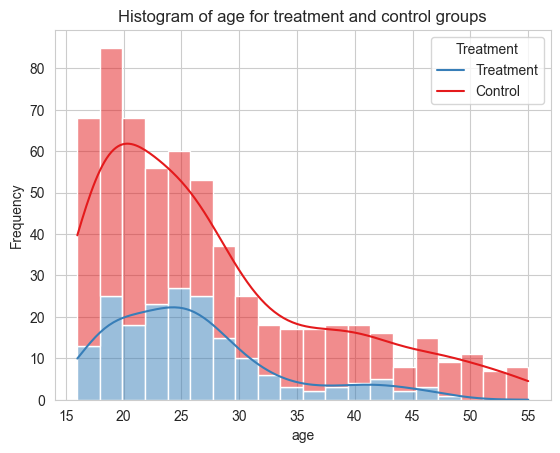

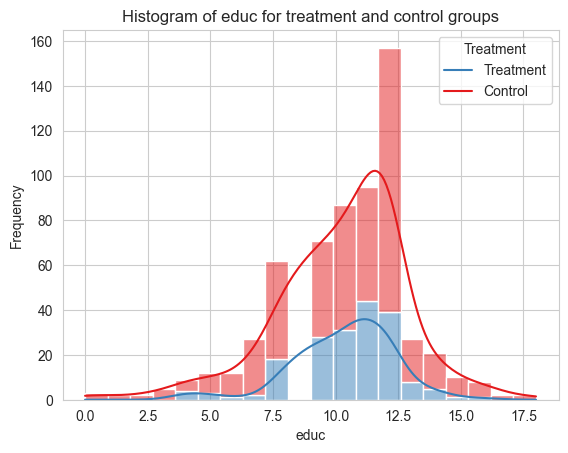

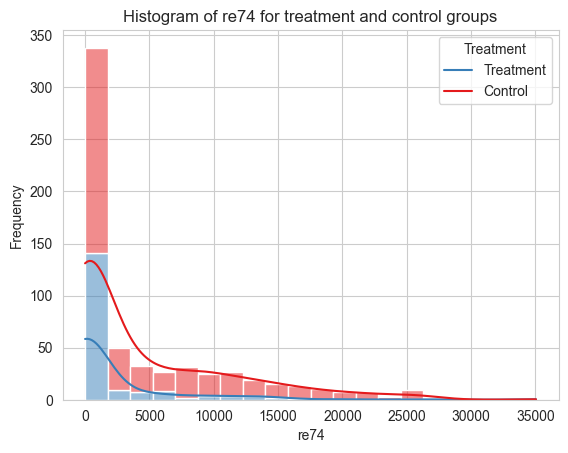

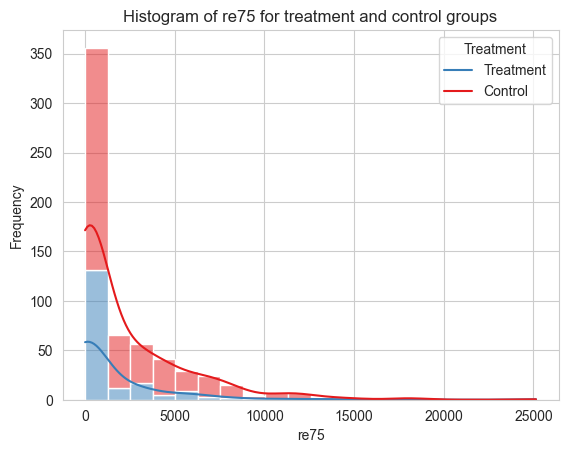

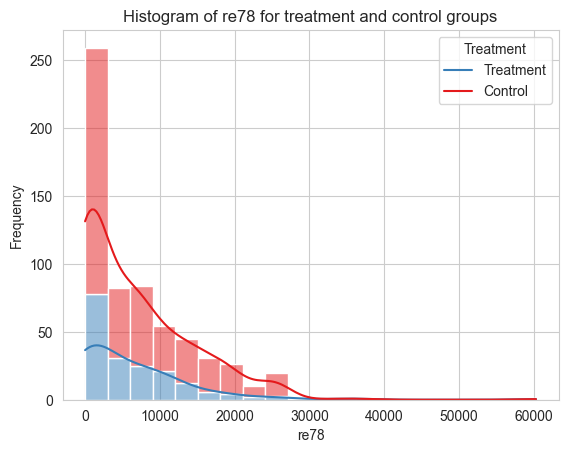

In [8]:
# For all non-binary features, plot histogram for control and treatment groups
for col in df.columns:
    if len(df[col].unique()) > 2:
        sns.set_style('whitegrid')
        sns.set_palette('Set1')
        sns.histplot(data=df, x=col, hue='treat', kde=True, bins=20, multiple='stack')
        plt.legend(title='Treatment', loc='upper right', labels=['Treatment', 'Control'])
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title('Histogram of {} for treatment and control groups'.format(col))
        plt.show()

<span style='color:indianred'>Discussion</span>  
The histogram plots and KDE for the selected features possess a similar shape, which corresponding increase and decrease in the values of the features. However, despite the similar shape, there seems to be a difference in the key statistics such as mean between the treatment and control group. For example, the age mean of the treatment group is 25.5, while the age mean of the control group is 28.5 which is also reflected in the KDE plot. The same pattern is observed for the other features. Because of that, we calculate the key statistics for each feature and compare them between the two groups. The results are shown in the table below.

In [9]:
# Find mean, median, variance, and standard deviation for all non-binary features for control and treatment groups
print('Group\t\tMean\t\tMedian\t\tVariance\tStandard Deviation')
print('-'*80)
for col in df.columns:
    if len(df[col].unique()) > 2:
        print('STATISTICS FOR {}'.format(col.upper()))
        print('Treatment\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}'.format(df[df['treat'] == 1][col].mean(), df[df['treat'] == 1][col].median(), df[df['treat'] == 1][col].var(), df[df['treat'] == 1][col].std()))
        print('Control\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}'.format(df[df['treat'] == 0][col].mean(), df[df['treat'] == 0][col].median(), df[df['treat'] == 0][col].var(), df[df['treat'] == 0][col].std()))
        print('-'*80)

Group		Mean		Median		Variance	Standard Deviation
--------------------------------------------------------------------------------
STATISTICS FOR AGE
Treatment	25.82		25.00		51.19		7.16
Control		28.03		25.00		116.35		10.79
--------------------------------------------------------------------------------
STATISTICS FOR EDUC
Treatment	10.35		11.00		4.04		2.01
Control		10.24		11.00		8.15		2.86
--------------------------------------------------------------------------------
STATISTICS FOR RE74
Treatment	2095.57		0.00		23879058.48		4886.62
Control		5619.24		2547.05		46087137.38		6788.75
--------------------------------------------------------------------------------
STATISTICS FOR RE75
Treatment	1532.06		0.00		10363576.16		3219.25
Control		2466.48		1086.73		10837238.87		3292.00
--------------------------------------------------------------------------------
STATISTICS FOR RE78
Treatment	6349.14		4232.31		61896017.66		7867.40
Control		6984.17		4975.51		53204796.23		7294.16
--------------------

<span style='color:indianred'>Discussion</span>  
Age is higher in the control group, and spreads more due to the higher variance. The years of education are similarly distributed, with mean and median being almost the same and the variance for control group is higher, but that doesn't raise any concerns here.  
The real difference that we can observe is in the real earnings in 1974 and 1975. The mean and median are both lower in the treatment group, which indicates that people who participated in the training program had comparatively lower incomes prior to participating in the program. The variance in these calculations, does not suggest any implications. 

In [10]:
# Find the percentage of degree holders in the treatment and control groups
print('Group\t\tDegree')
print('-'*80)
print('Treatment\t{:.2f}%'.format(df[df['treat'] == 1]['educ'].mean()))
print('Control\t\t{:.2f}%'.format(df[df['treat'] == 0]['educ'].mean()))

Group		Degree
--------------------------------------------------------------------------------
Treatment	10.35%
Control		10.24%


<span style='color:indianred'>Discussion</span>  
Both groups have a similar percentage of participants with a degree.

In [11]:
df['white'] = np.where((df['black'] == 0) & (df['hispan'] == 0), 1, 0)

# Find the percentage of each race in the treatment and control groups
print('Group\t\tBlack\t\tHispanic\tWhite')
print('-'*80)
print('Treatment\t{:.2f}%\t\t{:.2f}%\t\t{:.2f}%'.format(df[df['treat'] == 1]['black'].mean()*100, df[df['treat'] == 1]['hispan'].mean()*100, df[df['treat'] == 1]['white'].mean()*100))
print('Control\t\t{:.2f}%\t\t{:.2f}%\t\t{:.2f}%'.format(df[df['treat'] == 0]['black'].mean()*100, df[df['treat'] == 0]['hispan'].mean()*100, df[df['treat'] == 0]['white'].mean()*100))

Group		Black		Hispanic	White
--------------------------------------------------------------------------------
Treatment	84.32%		5.95%		9.73%
Control		20.28%		14.22%		65.50%


<span style='color:indianred'>Discussion</span>  
The ethnicity is where the most major difference is observed. The percentage of white people in the control group is 65.5% while it is only 9.73% in the treatment group. There are also more than two times hispanic people in the control group than in the treatment group. The deficit of these two races in the treatment group leads to a boom in the number of black people that participated in the program, being four times the number of people with the same race in the control group. The distributions are so different, that it can raise the question whether is program was targeting black people specifically.  
This major difference is certainly produces a bias in the data, and rejects the observations stated by the naive researcher.

### 1-3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum.

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.)


In [12]:
# Calculate the propensity score for each individual by training a logistic regression model on the whole dataset
from sklearn.linear_model import LogisticRegression
X = df.drop(['treat', 're78'], axis=1)
y = df['treat']
log_reg = LogisticRegression()
log_reg.fit(X, y)
df['prosperity_score'] = log_reg.predict_proba(X)[:, 1]

print('Treatment')
df[df['treat'] == 1].head()

Treatment


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,prosperity_score
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,0.523954
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,0.290854
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0,0.660646
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,0.693387
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,0.693109


In [13]:
print('Control')
df[df['treat'] == 0].head()

Control


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,prosperity_score
id,,,,,,,,,,,,
PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67,1,0.026683
PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67,1,0.019495
PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67,1,0.016216
PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01,1,0.019530
PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00,0,0.458992


### 1-4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

#### ** Bonus: Also, You can derive a mathematical model for this section. Your optimization problem should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

You don't need to implement this model and only need to write an optimization problem and proof theoretically that your model satisfies our goal.

<span style='color:indianred'>Discussion</span>

In [33]:
# Match treatment and control groups based on propensity score
import networkx as nx
G = nx.Graph()
# Add nodes of treatment and control groups to construct a bipartite graph
G.add_nodes_from(df[df['treat'] == 1].index, bipartite=0)
G.add_nodes_from(df[df['treat'] == 0].index, bipartite=1)
for i in df[df['treat'] == 1].index:
    for j in df[df['treat'] == 0].index:
        G.add_edge(i, j, weight=abs(df.loc[i, 'prosperity_score'] - df.loc[j, 'prosperity_score']))
# Match treatment and control groups based on minimum weight matching
matching = nx.min_weight_matching(G)

print('Treatment\tControl')
print('-'*80)
for i in list(matching)[:6]:
    print('{}\t\t{}'.format(i[0], i[1]))

Treatment	Control
--------------------------------------------------------------------------------
PSID406		NSW49
NSW128		PSID417
PSID199		NSW50
PSID277		NSW45
NSW185		PSID238
PSID400		NSW21


In [45]:
# If the first element in the tuple is from the control group, change the order of the tuple
for i in range(len(matching)):
    if matching[i][0] in df[df['treat'] == 0].index:
        matching[i] = (matching[i][1], matching[i][0])

print('Treatment\tControl')
print('-'*80)
for i in list(matching)[:6]:
    print('{}\t\t{}'.format(i[0], i[1]))

Treatment	Control
--------------------------------------------------------------------------------
NSW1		PSID213
NSW100		PSID339
NSW104		PSID374
NSW105		PSID388
NSW106		PSID295
NSW109		PSID40


### 1-5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.



### 1-6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project!

2-1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency (as you will see later in the course), is of great help when it comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


2-2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.


## Question 3: CAT or PERSON; Data Sources and Introduction to Pytorch
The purpose of this exercise is two-fold. First, you create an image dataset inheriting from `torch.utils.data.Dataset` by collecting images from two webpages providing AI-generated images to the public. This helps you to understand how data needed for a data science task might come from various sources other than locally stored images, structured files (like CSV), relational databases, etc. Also, people sometimes need to create their custom dataset for their research purposes. In the second part, you will train a neural network on the data using the pytorch framework.

<img src="./twoGoodFriends.jpg" width="400" height="272">


### 3-1. Installing Pytorch

Your job for this section is to install pytorch and the torchvision library. You may normally need torchvision in this exercise when handling images for converting images to torch tensors. For the sake of practicing, it might be good to try installing the libraries directly from your notebook. However, you can also do it from your system shell. Whatever you do, please share your work and the installation success message below. If executing shell commands for installation please share the screenshot of your terminal.

In [15]:
# You should insert something here for this part based on the above description.

### 3-2. Dataset
Take a look at [this interesting webpage](https://thisxdoesnotexist.com/) which shares AI-generated images and have some fun first! Well, we want to collect a dataset consisting of 50 images from [this url](https://thispersondoesnotexist.com/image) created by Phillip Wang and 50 images from [this one](https://thiscatdoesnotexist.com) created by Ryan Hoover. 
For creating the dataset you must inherit from `torch.utils.data.Dataset` and name your custom dataset class as `collected_2class_Dataset`

The `__init__()`, `__len__()` and `__getitem__()` methods of the class must be rewritten by you properly. 

The dataset must be designed in a way that by instantiation of the class, the data collection starts until all the samples are gathered. Your `__getitem__()` should also be coded in a way that `__getitem__(idx)` returns the data sample with the index `idx`. More precisely if your instance of `collected_2class_Dataset` is named `DS` and if:

`img, label = DS.__getitem__(someIndex)`, Then:

* `img` should be a torch tensor of size [1, 784] with data type float. The values must represent the scaled (to [0,1]) pixel values of the grayscale version of the images after being resized to 28x28.  
* `label` should be a torch tensor of a single element with data type long taking the value of 0 if the image is for a person and 1 if the image is related to a cat.

You might need to use additional packages like [Pillow](https://pypi.org/project/Pillow/) for image operations. Also, for requesting images from the websites you can follow different approaches. The simplest one might be running proper curl commands as shell commands from inside your python code. Use the following URLs for each resource to GET the images:
* https://thispersondoesnotexist.com/image
* https://thiscatdoesnotexist.com

Write code for your Dataset class definition and also any auxiliary functions if applicable. Please instantiate your class at the end of this code section.

In [16]:
# Your code for section 3.2

### 3-3. Dataloader
Using `torch.utils.data.random_split` split your dataset to train/test with the proportion of 70/30. Based on `torch.utils.data.DataLoader` create a DataLoader for train data and one for test data. The choice of the batch size is up to you, but try to use rational values.

In [17]:
# Your code for section 3.3

### 3-4. Training a NN Classifier
Inheriting from `torch.nn.Module` create a neural network for classifying the input images to person/cat. Use 2 hidden layers. Employ relu as the non-linearity (activation function) for the both hidden layers and sigmoid for the output. The choice of the number of nodes in the hidden layers is up to you. Train your network with the `torch.nn.CrossEntropyLoss` loss as objective function and use `torch.optim.Adam` as optimizer. Use 10 epochs of learning. Report the accuracy of classification at the end of each learning epoch by printing the values. 

In [18]:
# Your code for section 3.4

### 3-5. Testing the Trained Model
Examine the accuracy of your trained model on the test data prepared in section 3-5 and report the result.

In [19]:
# Your code for section 3.5

### 3-6. Is it Really Difficult to Distinguish Cats from Humans? 
Can you propose a rather simple rule-based system for doing this classification task? No code is needed for this part, just explain your ideas.

In [20]:
# Your code for section 3.6